# Using a convolutional neural network (CNN) to classify images of fashion objects

This notebook will implement a pre-existing CNN architecture developed for MNIST on the fashion-MNIST dataset, which contains photos of tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and boots. There are 60,000 training observations and 10,000 test observations, each of which corresponds to a 28x28 pixel image with 1 of the 10 potential labels listed above.

After implementing the pre-existing architecture on the new dataset, the alterations of the architecture will be tested in a factorial experiment exploring how batch size, number of features, and filter size impact training time and test accuracy.

In [2]:
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from math import floor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_filepath = pathlib.Path('drive/My Drive/fashion_mnist_data/fashion-mnist_train.csv')
test_filepath = pathlib.Path('drive/My Drive/fashion_mnist_data/fashion-mnist_test.csv')

## Implementing pre-existing architecture without changes

To obtain a baseline of how the pre-existing architecture performs on the fashion-MNIST dataset, the code in this section will:

1.   Define a class for the MNIST dataset
2.   Read the train and test data, splitting the training data into validation and training
3. Define a class for the simple CNN architecture
4. Set parameters including batch size, number of epochs, and learning rate
5. Train and test the model, using GPU if available



The first step

In [11]:
#Define custom class for MNIST dataset
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [12]:
#Read in training and testing data, splitting training data into training and validation sets
train_data = pl.read_csv(
    train_filepath
)

train_labels = train_data['label'].cast(pl.Int32).to_dummies()
train_features = train_data.drop('label')

X_train_val = train_features.to_numpy()
Y_train_val = train_labels.to_numpy()

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val,
    Y_train_val,
    test_size=0.20,
    random_state=42,
)

test_data = pl.read_csv(
    test_filepath
)

test_labels = train_data['label'].cast(pl.Int32).to_dummies()
test_features = train_data.drop('label')

X_test = test_features.to_numpy()
Y_test = test_labels.to_numpy()

#Use custom class to create MNIST dataset objects for the training, validation, and test sets
train_dataset = MNISTDataset(X_train, Y_train)
val_dataset = MNISTDataset(X_val, Y_val)
test_dataset = MNISTDataset(X_test, Y_test)

In [6]:
#Define custom class with pre-existing CNN architecture from MNIST model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [7]:
#Set parameters for training the model
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [13]:
#Create dataloaders for each of the datasets created above
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [15]:
#Train and test the simple CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Using device: cuda


NameError: name 'SimpleCNN' is not defined

Using this architecture with no changes from how it was developed for MNIST, we were able to train a model with 5 epochs in just under 19 seconds which had an accuracy of 91.46% on the test images. This performance is comparable to the performance of the architecture on the original MNIST dataset with the same parameters used for training.



## Experimenting with filter size, number of features, and batch size


In the original architecture above, we use a 3x3 filter size on the convolutional layers, 32 features in the first convolutional layer with 64 features in the second convolutional layer, and a batch size of 64. In the experiment below, we will test the impact of changes to the filter size, number of features, and batch size on the accuracy and training time of our CNN.

Multiple values are tested for each of these aspects, resulting in a total of 18 different combinations.

*   Filter sizes: 3x3, 5x5
*   Numbers of features in first convolutional layer: 16, 32, 64
*   Batch sizes: 32, 64, 128



The first step in our experiment is to list all of the parameters we will test, allowing us to iterate through these lists later on to efficiently identify all possible combinations of parameters. The num_features_options list will refer specifically to the number of features in the first convolutional layer, as the second convolutional layer will always be encoded as 2 * this number as is the relationship in the original architecture.

In [5]:
#Create lists of possible parameters to include in experiment
filter_size_options = [3,5]
num_features_options = [16, 32, 64]
batch_size_options = [32, 64, 128]

In [6]:
#Set stable training parameters
num_epochs = 5
learning_rate = 0.001

After preparing our parameter options, we need to do three things:



1. Understand the relationship between our varying parameters and each layer of the CNN
2. Create a system to collect the results of our experiment
3. Run our experiment


To understand the relationship between our varying parameters, we first revisit our original architecture. A few important things about the structure include:

* The input is 28x28, as is the fashion-MNIST input
* It has two convolutional layers, each of which is followed by a relu and a max pooling step using a 2x2 filter with stride 2
* It has two flattened layers before the final output layer

Considering this, our varying parameters in the experiment will have a complicated impact on many layers within the CNN. For example, if we change our filter size in the first convolutional layer from 3x3 to 5x5, we will have different dimensions on the input of our second convolutional layer and a different number of nodes in our flattening layer. So, while we can use largely the same code for this experiment as we did in our original implementation, we need to first define a function which will calculate the number of features and the dimensions of filters in each of our layers based on the parameters, so that we can use the output of this function to more efficientily create the custom CNN class for each step of our experiment.



In [7]:
#Define function to calculate parameters of custom CNN class based on experimental parameters
def calculate_experimental_parameters(num_features, filter_size):
    conv1_num_features = num_features
    conv2_num_features = 2 * conv1_num_features

    conv1_out_filter_dimension = 28 - filter_size + 1
    conv2_in_filter_dimension = conv1_out_filter_dimension // 2
    conv2_out_filter_dimension = conv2_in_filter_dimension - filter_size + 1

    flatten_layer_input = (floor((conv2_out_filter_dimension - 2) / 2) + 1) * (floor((conv2_out_filter_dimension - 2) / 2) + 1) * conv2_num_features

    return conv1_num_features, conv2_num_features, conv1_out_filter_dimension, conv2_in_filter_dimension, conv2_out_filter_dimension, flatten_layer_input

Now that we have a function to calculate the necessary information for defining our custom CNN classes, we have two remaining steps:

2. Create a system to collect the results of our experiment
3. Run our experiment

We are interested in two things, training time and testing accuracy. To examine these, we can create two empty lists and append the training time and test accuracy for each stage of the experiment to these lists, allowing us to analyze them later on.

In [8]:
#Create lists to collect results of each stage of experiment, as well as current hyperparameters
train_times = []
test_accuracies = []
filter_size_byexperiment = []
batch_size_byexperiment = []
num_features_byexperiment = []

Now that we have a plan to store the results, we can iterate through our lists of experimental parameters to create, train, and test our 18 different architectures.

In [16]:
#Iterate through experimental parameters and collect results
for filter_size in filter_size_options:
    for num_features in num_features_options:
        for batch_size in batch_size_options:

            #use function to calculate parameters for custom CNN class
            conv1_num_features, conv2_num_features, conv1_out_filter_dimension, conv2_in_filter_dimension, conv2_out_filter_dimension, flatten_layer_input = calculate_experimental_parameters(num_features, filter_size)

            #create the custom CNN with the parameters calculated above
            class ExperimentalCNN(nn.Module):
                  def __init__(self):
                      super(ExperimentalCNN, self).__init__()
                      self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_num_features, kernel_size=filter_size)
                      self.relu1 = nn.ReLU()
                      self.pool1 = nn.MaxPool2d(2, 2)
                      self.conv2 = nn.Conv2d(in_channels=conv1_num_features, out_channels=conv2_num_features, kernel_size=filter_size)
                      self.relu2 = nn.ReLU()
                      self.pool2 = nn.MaxPool2d(2, 2)
                      self.fc1 = nn.Linear(flatten_layer_input, 128)
                      self.relufc = nn.ReLU()
                      self.fc2 = nn.Linear(128, 10)


                  def forward(self, x):
                      x = self.conv1(x)
                      x = self.relu1(x)
                      x = self.pool1(x)
                      x = self.conv2(x)
                      x = self.relu2(x)
                      x = self.pool2(x)
                      x = x.view(-1, flatten_layer_input)
                      x = self.fc1(x)
                      x = self.relufc(x)
                      x = self.fc2(x)
                      return x

            #create the dataloaders
            train_loader = DataLoader(
                  dataset=train_dataset,
                  batch_size=batch_size,
                  shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=batch_size,
                shuffle=False,
            )
            test_loader = DataLoader(
                dataset=test_dataset,
                batch_size=batch_size,
                shuffle=False,
            )

            #train the CNN (on a GPU if available)
            torch.manual_seed(0)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(42)

            model = ExperimentalCNN().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            start_time = time.time()

            training_history = []
            for epoch in range(num_epochs):
                model.train()
                running_training_loss = 0.0
                for images, labels in train_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_training_loss += loss.item()

                training_loss = running_training_loss / len(train_loader)
                training_history.append({
                    'epoch': epoch+1,
                    'phase': 'Training',
                    'loss': training_loss
                })

                model.eval()
                running_val_loss = 0.0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images = images.unsqueeze(1).to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        running_val_loss += loss.item()

                validation_loss = running_val_loss / len(val_loader)
                training_history.append({
                    'epoch': epoch+1,
                    'phase': 'Validation',
                    'loss': validation_loss
                })

            end_time = time.time()
            elapsed_time = end_time - start_time
            train_times.append(elapsed_time)

            #test the CNN
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.unsqueeze(1).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.argmax(axis=1)).sum().item()
            test_accuracies.append(100 * correct / total)

            #append current hyperparameters to lists
            filter_size_byexperiment.append(filter_size)
            batch_size_byexperiment.append(batch_size)
            num_features_byexperiment.append(num_features)

In [17]:
#Join parameters and results into dataframe for analysis
test_num = list(range(1,19))
results = pl.DataFrame(
    {
        'test_number': test_num,
        'filter_size': filter_size_byexperiment,
        'num_features': num_features_byexperiment,
        'batch_size': batch_size_byexperiment,
        'test_accuracy': test_accuracies,
        'train_time': train_times,
    }
)

test_number,filter_size,num_features,batch_size,test_accuracy,train_time
i64,i64,i64,i64,f64,f64
1,3,16,32,91.313333,27.563569
2,3,16,64,90.486667,16.66248
3,3,16,128,91.175,12.514294
4,3,32,32,91.208333,33.625738
5,3,32,64,91.496667,23.799502
…,…,…,…,…,…
14,5,32,64,90.235,17.521324
15,5,32,128,90.798333,12.851968
16,5,64,32,89.85,32.747236


## Analyzing experimental results

To examine our experiments and determine the best hyperparameter combinations, we can create scatterplots which show both the training time and accuracy rates by test. Because the experiment was conducted using a set of nested loops, we know the patterns in which hyperparameters were used for which test. For example, there are two possible filter sizes, and this was the outermost loop in the experimental code. So, if there is a distinct difference between the first half of our experiments and the second half, that suggests that filter size may be the cause.

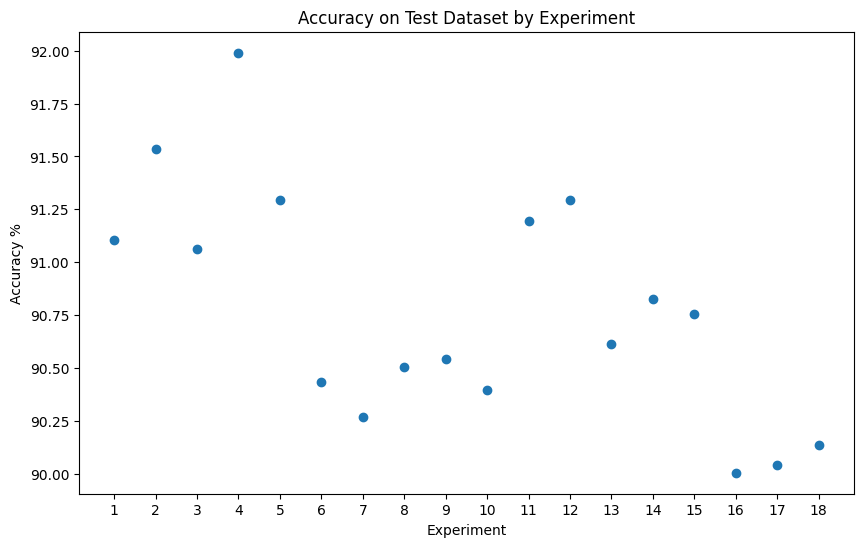

In [28]:

plt.figure(figsize=(10,6))
plt.scatter(test_num, test_accuracies)
plt.xticks(test_num)
plt.xlabel('Experiment')
plt.ylabel('Accuracy %')
plt.title('Accuracy on Test Dataset by Experiment')

plt.show()

While there does seem to be an overall negative trend across the experiments, we have to remember to consider them in groups based on the experimental parameters. If we take the first three experiments for an example, they have the same filter size (3x3) and the same number of features (16), but have batch sizes of 32, 64, and 128 respectively. Within this set, it seems the best accuracy came from the batch size of 64. If we look at the other triples such as experiments 4, 5, 6 and 7, 8, 9, this trend doesn't seem to be consistent. We might expect that smaller batch sizes would lead to higher accuracies by providing more opportunities for tuning, but the pattern is not strong.


Looking next at numbers of features, we can group every third experiment together. For example, experiments 1, 4, and 7 will have the same filter size and batch size, but different numbers of features. In this specific group, there appears to be another trend where the largest number of features has the smallest accuracy. Out of experiments 1, 4, and 7, the latter had the lowest accuracy. Though in experiments 2, 5, and 8, the fifth experiment actually has the lowest accuracy, the eighth experiment returned similar results. To make more definitive conclusions about the relationship between number of features and accuracy, we would need to explore more options for number of features and create a larger set of experiments to consider.


Looking next at filter size, we can compare the first half of experiments to the second half. These two sets of experiments seem to have similar shapes, with later experiments within each group having lower accuracies. The second set of experiments, using a filter size of 5x5, are generally lower than the first half, using a filter size of 3x3. This suggests that a smaller filter size leads to more accurate performance, which aligns with what we would expect since these filters work with more specificity and preserve a greater level of detail about their inputs.


With this knowledge of filter sizes, and the observation that the first and second half of the experiments follow similar patterns, we can also incorporate our earlier observations about batch size and number of features to understand how these hyperparameters may influence each other. It seems that within a given filter size, it is ideal to have a smaller number of features, though we are unsure of what batch size would be ideal.


To understand more thoroughly which hyperparameters are ideal, we can next examine their impact on training time.

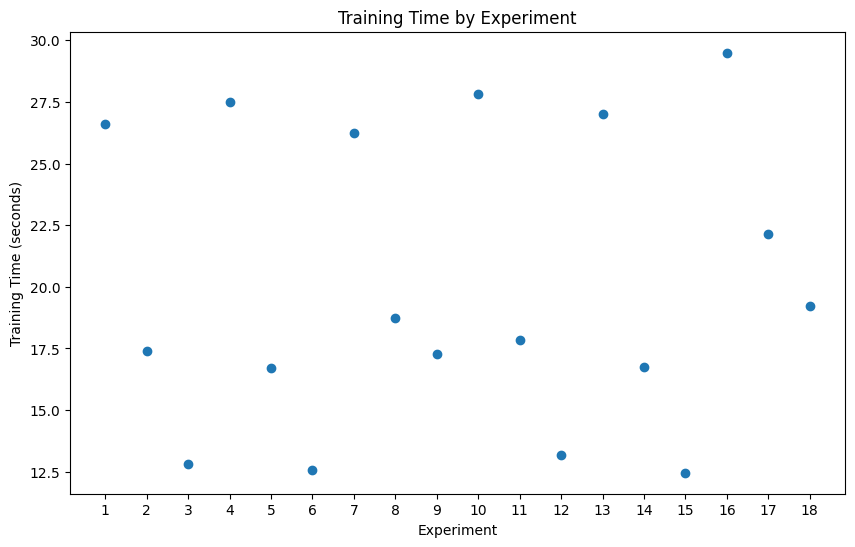

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(test_num, train_times)
plt.xticks(test_num)
plt.xlabel('Experiment')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time by Experiment')

plt.show()

In this plot, we immediately see a pattern that we can attribute to batch size. Within each set of 3 experiments where filter size and number of features are held constant, the fastest experiment was that which had the largest batch size. This makes sense, as completing each of our epochs would require fewer steps if we work with a larger batch size.


Beyond this conclusion about batch size, it's difficult to identify strong relationships between training time and either filter size or number of features. However, we did have important observations about these two hyperparameters based on accuracy. Now, we can combine this with our insight on batch sizes and training time for a more complete image of hyperparameters for our CNN.


To improve our accuracy, we want to use a smaller filter size with and a smaller number of features. To balance this with a short training time, we can select a larger batch size. The experiment with the smallest filter size (3), smallest number of features (16), and largest batch size (128) is experiment 3.


Experiment 3 is not the most accurate experiment, nor is it the most efficient, but it does perform really well in both areas. Our ideal hyperparameters need to consider trade-offs between optimizing accuracy and optimizing training time in order to be computationally efficient and effective. If we chose simply based on accuracy, we'd have experiment 4, which our scatterplot shows clearly has one of the highest training times. If we chose simply based on training time, we'd have experiment 15, which is very average in terms of its accuracy. While more information about our goals with this task would help us understand the relative importance of accuracy and training time, it's important to note that we generally want to consider both metrics and look for a set of hyperparameters which do generally well in both, rather than really well in one metric and really poorly in another.